In [70]:
import pandas as pd
import numpy as np
import math
import h5py
from qkeras import *
from qkeras import utils
import tensorflow as tf
from sklearn.model_selection import train_test_split
print(tf.__version__)
from tensorflow.keras.models import Sequential, Model,model_from_json
from keras.layers import Input,Dense, BatchNormalization
from keras import initializers, regularizers, optimizers, losses
from nn_globals import *
from nn_encode_displ import nlayers, nvariables
from nn_models import (lr_decay, modelbestcheck, modelbestcheck_weights)
from nn_training import train_model
from nn_models import load_my_model, update_keras_custom_objects
from keras.models import Model
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

# Setup matplotlib
plt.style.use('tdrstyle.mplstyle')

from nn_plotting import (gaus, fit_gaus, np_printoptions, \
                         find_efficiency_errors)

eps = 1e-7
my_cmap = plt.cm.viridis
my_cmap.set_under('w',1)
my_palette = ("#377eb8", "#e41a1c", "#984ea3", "#ff7f00", "#4daf4a")

2.4.1


<ipython-input-70-1d3da5d30478>:29: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("viridis"))
  my_cmap.set_under('w',1)


In [71]:
class evaluate:
    def __init__(self,X_test,y_test):
        self.X = X_test
        self.y = y_test[0]
        self.dxy = y_test[1]
    
    def compute_data_statistics(self,ctype = "y",label="data"):
        if ctype == "y":
            x = self.recalibrate(self.y,reg_pt_scale)
            x = x**(-1)
        else:
            x = self.recalibrate(self.dxy,reg_dxy_scale)
        df_describe = pd.DataFrame(x, columns = [label])
        print(df_describe.describe())
    
    def rmse(self,y_true, y_predicted):
        assert(y_true.shape[0] == y_predicted.shape[0])
        n = y_true.shape[0]
        sum_square = np.sum((y_true - y_predicted)**2)
        return math.sqrt(sum_square/n)
    
    def adjusted_r_2(self,y_true, y_predicted):
        y_addC = sm.add_constant(y_true)
        result = sm.OLS(y_predicted, y_addC).fit()
        print(result.rsquared, result.rsquared_adj)

    def recalibrate(self,x,scale):
        return x/scale
    
    def inverse(self,arr):
        arr_inv = 1./arr
        arr_inv[arr_inv == np.inf] = 0.
        return arr_inv
    
    def predict(self,model,batch_size = 256):
        y_test_true = self.recalibrate(self.y,reg_pt_scale)
        dxy_test_true = self.recalibrate(self.dxy, reg_dxy_scale)
        
        y_test = model.predict(self.X,batch_size = 2000)
        y_test_meas = y_test[:,0]
        dxy_test_meas = y_test[:,1]
        y_test_meas = self.recalibrate(y_test_meas,reg_pt_scale)
        dxy_test_meas = self.recalibrate(dxy_test_meas,reg_dxy_scale)   
    
        y_test_meas = y_test_meas.reshape(-1)
        dxy_test_meas = dxy_test_meas.reshape(-1)

        return y_test_meas, dxy_test_meas
    
#     def compute_error(self,y_predicted,ctype = "y"):
#         if ctype == "y":
#             y_test_true = self.recalibrate(self.y,reg_pt_scale)
#             print("RMSE Error for momentum:",self.rmse(self.inverse(y_test_true),\
#                                                                               self.inverse(y_predicted)))
#         else:
#             dxy_test_true = self.recalibrate(self.dxy, reg_dxy_scale)
#             print("RMSE Error for dxy:",self.rmse(dxy_test_true,y_predicted))

    def get_error(self,y_predicted,ctype = "y"):
        if ctype == "y":
            y_test_true = self.recalibrate(self.y,reg_pt_scale)
            return self.rmse(self.inverse(y_test_true),self.inverse(y_predicted))
        else:
            dxy_test_true = self.recalibrate(self.dxy, reg_dxy_scale)
            return self.rmse(dxy_test_true,y_predicted)

def k_fold_validation(model, x, y, dxy, folds =10):
    x_copy = np.copy(x)
    y_copy = np.copy(y)
    dxy_copy = np.copy(dxy)
    assert x_copy.shape[0] == y_copy.shape[0] == dxy_copy.shape[0]
    fold_size = int(x_copy.shape[0] / folds)
    x_splits, y_splits, dxy_splits = [], [], []
    for i in range(folds):
        indices = np.random.choice(x_copy.shape[0],fold_size, replace=False)  
        x_splits.append(x_copy[indices])
        y_splits.append(y_copy[indices])
        dxy_splits.append(dxy_copy[indices])
        x_copy = np.delete(x_copy,indices,axis = 0)
        y_copy = np.delete(y_copy,indices,axis = 0)
        dxy_copy = np.delete(dxy_copy,indices,axis = 0)
    rmse_y, rmse_dxy = [],[]
    for i in range(folds):
        evaluate_obj = evaluate(x_splits[i], tuple([y_splits[i],dxy_splits[i]]))
        y_predicted , dxy_predicted = evaluate_obj.predict(model = model)
        rmse_y.append(evaluate_obj.get_error(y_predicted,ctype="y"))
        rmse_dxy.append(evaluate_obj.get_error(dxy_predicted,ctype="dxy"))
    print('Average RMSE for '+ str(folds) + '-fold cv for y:', np.mean(rmse_y))
    print('Average RMSE for '+ str(folds) + '-fold cv for dxy:', np.mean(rmse_dxy))
    
def huber_loss(y_true, y_pred, delta=1.345):
    x = K.abs(y_true - y_pred)
    squared_loss = 0.5*K.square(x)
    absolute_loss = delta * (x - 0.5*delta)
    #xx = K.switch(x < delta, squared_loss, absolute_loss)
    xx = tf.where(x < delta, squared_loss, absolute_loss)  # needed for tensorflow
    return K.mean(xx, axis=-1)

def get_sparsity(weights):
    """
    Code borrowed from https://github.com/google/qkeras/blob/master/qkeras/utils.py#L937
    Returns the sparsity as the ratio of non-zero weights to the total weights within the weights matrix.
    """
    return 1.0 - np.count_nonzero(weights) / float(weights.size)

In [72]:
infile_muon_displ = "NN_input_params_FlatXYZ.npz"

nentries = 100000000

def _handle_nan_in_x(x):
    x[np.isnan(x)] = 0.0
    x[x==-999.0] = 0.0
    return x

def _zero_out_x(x):
    x = 0.0
    return x
    
def _fixME1Ring(x):
    for i in range(len(x)):
        if (x[i,0] != 0.0): x[i,18] = x[i,18] + 1
    return x   

def muon_data(filename, reg_pt_scale=1.0, reg_dxy_scale=1.0, correct_for_eta=False):
    try:
        logger.info('Loading muon data from {0} ...'.format(filename))
        loaded = np.load(filename)
        the_variables = loaded['variables']
        the_parameters = loaded['parameters']
        # print(the_variables.shape)
        the_variables = the_variables[:nentries]
        the_parameters = the_parameters[:nentries]
        logger.info('Loaded the variables with shape {0}'.format(the_variables.shape))
        logger.info('Loaded the parameters with shape {0}'.format(the_parameters.shape))
    except:
        logger.error('Failed to load data from file: {0}'.format(filename))

    assert(the_variables.shape[0] == the_parameters.shape[0])
    _handle_nan_in_x(the_variables)
      #_fixME1Ring(the_variables)
    _handle_nan_in_x(the_parameters)
    mask = np.logical_or(np.logical_or( np.logical_or((the_variables[:,23] == 11), (the_variables[:,23] == 13)), (the_variables[:,23] == 14)),(the_variables[:,23] == 15)) 

    the_variables = the_variables[mask]  
    the_parameters = the_parameters[mask]  
    assert(the_variables.shape[0] == the_parameters.shape[0])

    x = the_variables[:,0:23]
    y = reg_pt_scale*the_parameters[:,0]
#    print (x[0:30,:], the_variables[0:30,23])
#    print (y[0:30])
    phi = the_parameters[:,1] 
    eta = the_parameters[:,2] 
    vx = the_parameters[:,3] 
    vy = the_parameters[:,4] 
    vz = the_parameters[:,5]      
    dxy = vy * np.cos(phi) - vx * np.sin(phi) 
    dz = vz
    w = np.abs(y)/0.2 + 1.0
    x_mask = the_parameters[:,5]
    x_road = the_parameters[:,5] 
    _zero_out_x(x_mask)
    _zero_out_x(x_road)  
    logger.info('Loaded the encoded variables with shape {0}'.format(x.shape))
    logger.info('Loaded the encoded parameters with shape {0}'.format(y.shape))

    return x, y, dxy, dz, w, x_mask, x_road

def muon_data_split(filename, reg_pt_scale=1.0, reg_dxy_scale=1.0, test_size=0.5, correct_for_eta=False):
    x, y, dxy, dz, w, x_mask, x_road = muon_data(filename, reg_pt_scale=reg_pt_scale, reg_dxy_scale=reg_dxy_scale, correct_for_eta=correct_for_eta)

    # Split dataset in training and testing
    x_train, x_test, y_train, y_test, dxy_train, dxy_test, dz_train, dz_test, w_train, w_test, x_mask_train, x_mask_test, x_road_train, x_road_test = train_test_split(x, y, dxy, dz, w, x_mask, x_road, test_size=test_size)
    logger.info('Loaded # of training and testing events: {0}'.format((x_train.shape[0], x_test.shape[0])))

    # Check for cases where the number of events in the last batch could be too few
    validation_split = 0.1
    train_num_samples = int(x_train.shape[0] * (1.0-validation_split))
    val_num_samples = x_train.shape[0] - train_num_samples
    batch_size = 128
    if (train_num_samples%batch_size) < 100:
        logger.warning('The last batch for training could be too few! ({0}%{1})={2}. Please change test_size.'.format(train_num_samples, batch_size, train_num_samples%batch_size))
        logger.warning('Try this formula: int(int({0}*{1})*{2}) % 128'.format(x.shape[0], 1.0-test_size, 1.0-validation_split))
    train_num_samples = int(x_train.shape[0] * 2 * (1.0-validation_split))
    val_num_samples = x_train.shape[0] - train_num_samples
    batch_size = 128
    if (train_num_samples%batch_size) < 100:
        logger.warning('The last batch for training after mixing could be too few! ({0}%{1})={2}. Please change test_size.'.format(train_num_samples, batch_size, train_num_samples%batch_size))
        logger.warning('Try this formula: int(int({0}*{1})*2*{2}) % 128'.format(x.shape[0], 1.0-test_size, 1.0-validation_split))
    return x_train, x_test, y_train, y_test, dxy_train, dxy_test, dz_train, dz_test, w_train, w_test, x_mask_train, x_mask_test, x_road_train, x_road_test

In [73]:
# Import muon data
# 'x' is the array of input variables, 'y' is the q/pT
x_train_displ, x_test_displ, y_train_displ, y_test_displ, dxy_train_displ, dxy_test_displ, dz_train_displ, dz_test_displ, \
w_train_displ, w_test_displ, x_mask_train_displ, x_mask_test_displ, x_road_train_displ, x_road_test_displ = \
      muon_data_split(infile_muon_displ, reg_pt_scale=reg_pt_scale, reg_dxy_scale=reg_dxy_scale, test_size=0.315)

y_train_displ = np.abs(y_train_displ)
y_test_displ = np.abs(y_test_displ)


[INFO    ] Loading muon data from NN_input_params_FlatXYZ.npz ...
[INFO    ] Loaded the variables with shape (19300000, 25)
[INFO    ] Loaded the parameters with shape (19300000, 6)
[INFO    ] Loaded the encoded variables with shape (3284620, 23)
[INFO    ] Loaded the encoded parameters with shape (3284620,)
[INFO    ] Loaded # of training and testing events: (2249964, 1034656)
[WARNING ] The last batch for training could be too few! (2024967%128)=7. Please change test_size.
[WARNING ] Try this formula: int(int(3284620*0.685)*0.9) % 128
[WARNING ] The last batch for training after mixing could be too few! (4049935%128)=15. Please change test_size.
[WARNING ] Try this formula: int(int(3284620*0.685)*2*0.9) % 128


### Pre-Quantization Data Analysis:

In [74]:
# # Analysing dependencies in the data
# x = np.concatenate((x_train_displ,x_test_displ),axis=0)
# y = np.concatenate((y_train_displ,y_test_displ),axis=0)
# dxy = np.concatenate((dxy_train_displ,dxy_test_displ),axis=0)

# df = pd.DataFrame(x, columns = ["dphi_1","dphi_2","dphi_3","dphi_4","dphi_5","dphi_6",
#                                            "dtheta_1","dtheta_2","dtheta_3","dtheta_4","dtheta_5", "dtheta_6",
#                                            "bend_1","bend_2","bend_3","bend_4",
#                                            "FR","track theta","ME11",
#                                            "RPC_1","RPC_2","RPC_3","RPC_4"])
# df["Target momentum"] = y
# df["Target dxy"] = dxy
# # C_mat = df[["dphi_1","dphi_2","dphi_3","dphi_4","dphi_5","dphi_6",
# #             "dtheta_1","dtheta_2","dtheta_3","dtheta_4","dtheta_5", "dtheta_6",
# #            "track theta","Target momentum", "Target dxy"]].corr()
# C_mat = df.corr()
# fig = plt.figure(figsize = (7,7),dpi = 100)
# sns.heatmap(C_mat, vmax = .8, square = True,cmap = "YlGnBu")
# plt.show()

In [75]:
# y = np.concatenate((y_train_displ, y_test_displ))
# dxy = np.concatenate((dxy_train_displ, dxy_test_displ))
# assert(y.shape[0] == dxy.shape[0])
# stats = evaluate(x_train_displ,tuple([y,dxy]))
# stats.compute_data_statistics(ctype="y",label = "momentum")

In [76]:
# stats.compute_data_statistics(ctype="dxy",label="dxy")

### Defining the Quantized Model:

In [77]:
def create_model_quantized(nvariables, lr=0.001, clipnorm=10., initializer = "he_uniform",
                           nodes1=64, nodes2=32, nodes3=16, outnodes=2,
                          l1_reg = 0.0, l2_reg = 0.0):
    regularizer = regularizers.L1L2(l1=l1_reg, l2=l2_reg)
    bn_momentum = 0.9
    eps = 1e-4
    x = x_in = Input((nvariables,))
    x = QBatchNormalization(epsilon=eps, momentum=bn_momentum,name="bn-input")(x)
    
    x = QDense(nodes1, 
               kernel_quantizer="quantized_bits(bits=10,integer=5,symmetric=False,use_stochastic_rounding=True)",
               kernel_initializer=initializer,
               use_bias = False,
               kernel_regularizer = regularizer,
               name="hidden-dense-1")(x)
    x = QBatchNormalization(epsilon=eps, 
                            momentum=bn_momentum,
                            beta_quantizer='quantized_tanh(bits=5, symmetric = False,use_stochastic_rounding=True)',
                            gamma_quantizer='quantized_tanh(bits=5, symmetric = False,use_stochastic_rounding=True)',
                            mean_quantizer = 'quantized_tanh(bits=5, symmetric = False,use_stochastic_rounding=True)',
                            variance_quantizer = 'quantized_tanh(bits=5, symmetric = False,use_stochastic_rounding=True)',
                            name="bn-1")(x)
    x = QActivation(activation="quantized_relu(bits=10,integer=5,use_sigmoid=True,use_stochastic_rounding=True)",
                    name="act_1")(x)
    
    if nodes2:
    
        x = QDense(nodes2, 
                   kernel_quantizer="quantized_bits(bits=10,integer=5,symmetric=False,use_stochastic_rounding=True)", 
                   kernel_initializer=initializer,
                   use_bias = False,
                   kernel_regularizer = regularizer,
                   name="hidden-dense-2")(x)
        x = QBatchNormalization(epsilon=eps, 
                                momentum=bn_momentum,
                                beta_quantizer='quantized_tanh(bits=5, symmetric = False,use_stochastic_rounding=True)',
                                gamma_quantizer='quantized_tanh(bits=5, symmetric = False,use_stochastic_rounding=True)',
                                mean_quantizer = 'quantized_tanh(bits=5, symmetric = False,use_stochastic_rounding=True)',
                                variance_quantizer = 'quantized_tanh(bits=5, symmetric = False,use_stochastic_rounding=True)',
                                name="bn-2")(x)
        x = QActivation(activation="quantized_relu(bits=10,integer=5, use_sigmoid=True,use_stochastic_rounding=True)", 
                        name="act_2")(x)
        
        if nodes3:

            x = QDense(nodes3, 
                       kernel_quantizer="quantized_bits(bits=10,integer=5,symmetric=False,use_stochastic_rounding=True)", 
                       kernel_initializer=initializer,
                       kernel_regularizer = regularizer,
                       use_bias = False,
                       name="hidden-dense-3")(x)
            x = QBatchNormalization(epsilon=eps, 
                                    momentum=bn_momentum,
                                    beta_quantizer='quantized_tanh(bits=5, symmetric = False,use_stochastic_rounding=True)',
                                    gamma_quantizer='quantized_tanh(bits=5, symmetric = False,use_stochastic_rounding=True)',
                                    mean_quantizer = 'quantized_tanh(bits=5, symmetric = False,use_stochastic_rounding=True)',
                                    variance_quantizer = 'quantized_tanh(bits=5, symmetric = False,use_stochastic_rounding=True)',
                                    name="bn-3")(x)
            x = QActivation(activation="quantized_relu(bits=10,integer=5, use_sigmoid=True,use_stochastic_rounding=True)", 
                            name="act_3")(x)

    x = QDense(outnodes,
                kernel_quantizer="quantized_bits(bits=10,integer=5,symmetric=False,use_stochastic_rounding=True)",
                kernel_initializer = initializer,
                use_bias = True,
                name="dense-output")(x)
    x = Activation("linear")(x)
    
    model = Model(inputs=x_in, outputs=x,name="qmodel")
    
    adam = optimizers.Adam(lr=lr, clipnorm=clipnorm)
    model.compile(optimizer=adam, loss=huber_loss, metrics=['accuracy'])
    model.summary()
    
    return model
    

In [78]:
assert(keras.backend.backend() == 'tensorflow')

# Bits = 16, Int = 8
# Best Perf w/ quantized_tanh(bits=8, symmetric = False,use_stochastic_rounding=True)
# normal_epochs = 300
# normal_batch_size = 1000
# l1_reg = 0.0
# l2_reg = 0.0
# learning_rate = 1e-3

# Bits = 12, Int = 6
# quantized_tanh(bits=12, symmetric = False,use_stochastic_rounding=True)
# Bits = 10, Int = 5
# quantized_tanh(bits=5, symmetric = False,use_stochastic_rounding=True)

normal_epochs = 300
normal_batch_size = 1000
l1_reg = 0.0
l2_reg = 1e-4
learning_rate = 1e-3

qmodel = create_model_quantized(nvariables=nvariables, 
                                lr=learning_rate, 
                                clipnorm=gradient_clip_norm, 
                                nodes1=20, nodes2=15, nodes3=10, 
                                outnodes=2,
                                l1_reg = l1_reg, 
                                l2_reg = l2_reg)

logger.info('Training model with l1_reg: {0} l2_reg: {1}'.format(l1_reg, l2_reg))

history = train_model(qmodel, x_train_displ, np.column_stack((y_train_displ, dxy_train_displ)),
                      save_model=False, 
                      epochs=normal_epochs, 
                      batch_size=normal_batch_size,
                      callbacks=[lr_decay], 
                      validation_split=0.1, 
                      verbose=True)

metrics = [len(history.history['loss']), history.history['loss'][-1], history.history['val_loss'][-1]]
logger.info('Epoch {0}/{0} - loss: {1} - val_loss: {2}'.format(*metrics))

[INFO    ] Training model with l1_reg: 0.0 l2_reg: 0.0001
[INFO    ] Begin training ...


Model: "qmodel"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 23)]              0         
_________________________________________________________________
bn-input (QBatchNormalizatio (None, 23)                92        
_________________________________________________________________
hidden-dense-1 (QDense)      (None, 20)                460       
_________________________________________________________________
bn-1 (QBatchNormalization)   (None, 20)                80        
_________________________________________________________________
act_1 (QActivation)          (None, 20)                0         
_________________________________________________________________
hidden-dense-2 (QDense)      (None, 15)                300       
_________________________________________________________________
bn-2 (QBatchNormalization)   (None, 15)                60   

2025/2025 [==============================] - 5s 2ms/step - loss: 11.0478 - accuracy: 0.9346 - val_loss: 10.5398 - val_accuracy: 0.9378
Epoch 28/300

Epoch 00028: LearningRateScheduler reducing learning rate to 0.0008100000559352338.
2025/2025 [==============================] - 5s 2ms/step - loss: 10.9780 - accuracy: 0.9352 - val_loss: 10.7371 - val_accuracy: 0.9374
Epoch 29/300

Epoch 00029: LearningRateScheduler reducing learning rate to 0.0008100000559352338.
2025/2025 [==============================] - 5s 2ms/step - loss: 11.1465 - accuracy: 0.9349 - val_loss: 11.2031 - val_accuracy: 0.9348
Epoch 30/300

Epoch 00030: LearningRateScheduler reducing learning rate to 0.0008100000559352338.
2025/2025 [==============================] - 5s 2ms/step - loss: 11.0703 - accuracy: 0.9350 - val_loss: 10.5608 - val_accuracy: 0.9372
Epoch 31/300

Epoch 00031: LearningRateScheduler reducing learning rate to 0.0007290000503417104.
2025/2025 [==============================] - 5s 2ms/step - loss: 10.

2025/2025 [==============================] - 5s 3ms/step - loss: 10.6870 - accuracy: 0.9360 - val_loss: 10.4684 - val_accuracy: 0.9378
Epoch 98/300

Epoch 00098: LearningRateScheduler reducing learning rate to 0.0003874205285683274.
2025/2025 [==============================] - 5s 3ms/step - loss: 10.7195 - accuracy: 0.9356 - val_loss: 10.4018 - val_accuracy: 0.9377
Epoch 99/300

Epoch 00099: LearningRateScheduler reducing learning rate to 0.0003874205285683274.
2025/2025 [==============================] - 5s 3ms/step - loss: 10.6753 - accuracy: 0.9361 - val_loss: 10.4348 - val_accuracy: 0.9375
Epoch 100/300

Epoch 00100: LearningRateScheduler reducing learning rate to 0.0003874205285683274.
2025/2025 [==============================] - 5s 3ms/step - loss: 10.7083 - accuracy: 0.9356 - val_loss: 11.1101 - val_accuracy: 0.9372
Epoch 101/300

Epoch 00101: LearningRateScheduler reducing learning rate to 0.0003486784757114947.
2025/2025 [==============================] - 5s 3ms/step - loss: 1

2025/2025 [==============================] - 5s 3ms/step - loss: 10.7004 - accuracy: 0.9361 - val_loss: 10.4191 - val_accuracy: 0.9391
Epoch 133/300

Epoch 00133: LearningRateScheduler reducing learning rate to 0.00025418659788556397.
2025/2025 [==============================] - 5s 3ms/step - loss: 10.7007 - accuracy: 0.9357 - val_loss: 10.8801 - val_accuracy: 0.9358
Epoch 134/300

Epoch 00134: LearningRateScheduler reducing learning rate to 0.00025418659788556397.
2025/2025 [==============================] - 5s 3ms/step - loss: 10.7230 - accuracy: 0.9356 - val_loss: 10.5134 - val_accuracy: 0.9364
Epoch 135/300

Epoch 00135: LearningRateScheduler reducing learning rate to 0.00025418659788556397.
2025/2025 [==============================] - 5s 3ms/step - loss: 10.6958 - accuracy: 0.9357 - val_loss: 10.4631 - val_accuracy: 0.9389
Epoch 136/300

Epoch 00136: LearningRateScheduler reducing learning rate to 0.00025418659788556397.
2025/2025 [==============================] - 5s 3ms/step - l

2025/2025 [==============================] - 5s 3ms/step - loss: 10.6948 - accuracy: 0.9360 - val_loss: 10.3542 - val_accuracy: 0.9378
Epoch 168/300

Epoch 00168: LearningRateScheduler reducing learning rate to 0.0001853020366979763.
2025/2025 [==============================] - 5s 3ms/step - loss: 10.6786 - accuracy: 0.9361 - val_loss: 10.3642 - val_accuracy: 0.9388
Epoch 169/300

Epoch 00169: LearningRateScheduler reducing learning rate to 0.0001853020366979763.
2025/2025 [==============================] - 5s 3ms/step - loss: 10.6603 - accuracy: 0.9362 - val_loss: 10.9997 - val_accuracy: 0.9333
Epoch 170/300

Epoch 00170: LearningRateScheduler reducing learning rate to 0.0001853020366979763.
2025/2025 [==============================] - 5s 3ms/step - loss: 10.7078 - accuracy: 0.9359 - val_loss: 10.3865 - val_accuracy: 0.9382
Epoch 171/300

Epoch 00171: LearningRateScheduler reducing learning rate to 0.00016677183302817866.
2025/2025 [==============================] - 5s 3ms/step - loss

2025/2025 [==============================] - 6s 3ms/step - loss: 11.4194 - accuracy: 0.9338 - val_loss: 11.0242 - val_accuracy: 0.9369
Epoch 203/300

Epoch 00203: LearningRateScheduler reducing learning rate to 0.0001215766606037505.
2025/2025 [==============================] - 6s 3ms/step - loss: 11.2931 - accuracy: 0.9344 - val_loss: 11.1611 - val_accuracy: 0.9358
Epoch 204/300

Epoch 00204: LearningRateScheduler reducing learning rate to 0.0001215766606037505.
2025/2025 [==============================] - 6s 3ms/step - loss: 11.2219 - accuracy: 0.9340 - val_loss: 10.6098 - val_accuracy: 0.9383
Epoch 205/300

Epoch 00205: LearningRateScheduler reducing learning rate to 0.0001215766606037505.
2025/2025 [==============================] - 7s 3ms/step - loss: 11.1070 - accuracy: 0.9346 - val_loss: 10.7206 - val_accuracy: 0.9377
Epoch 206/300

Epoch 00206: LearningRateScheduler reducing learning rate to 0.0001215766606037505.
2025/2025 [==============================] - 6s 3ms/step - loss:

2025/2025 [==============================] - 6s 3ms/step - loss: 10.7689 - accuracy: 0.9360 - val_loss: 10.3454 - val_accuracy: 0.9378
Epoch 238/300

Epoch 00238: LearningRateScheduler reducing learning rate to 8.862938557285815e-05.
2025/2025 [==============================] - 5s 3ms/step - loss: 10.7436 - accuracy: 0.9362 - val_loss: 10.3542 - val_accuracy: 0.9389
Epoch 239/300

Epoch 00239: LearningRateScheduler reducing learning rate to 8.862938557285815e-05.
2025/2025 [==============================] - 5s 3ms/step - loss: 10.7441 - accuracy: 0.9357 - val_loss: 10.5596 - val_accuracy: 0.9378
Epoch 240/300

Epoch 00240: LearningRateScheduler reducing learning rate to 8.862938557285815e-05.
2025/2025 [==============================] - 5s 3ms/step - loss: 10.7381 - accuracy: 0.9360 - val_loss: 10.4730 - val_accuracy: 0.9388
Epoch 241/300

Epoch 00241: LearningRateScheduler reducing learning rate to 7.976644701557234e-05.
2025/2025 [==============================] - 5s 3ms/step - loss:

[INFO    ] Done training. Time elapsed: 0:27:18.132787 sec
[INFO    ] Epoch 300/300 - loss: 10.73487663269043 - val_loss: 11.53423023223877


In [79]:
x = np.concatenate((x_train_displ, x_test_displ),axis = 0)
y = np.concatenate((y_train_displ, y_test_displ),axis = 0)
dxy = np.concatenate((dxy_train_displ, dxy_test_displ),axis = 0)
k_fold_validation(model = qmodel, 
                  x = x,  
                  y = y, 
                  dxy = dxy, 
                  folds =50)

Average RMSE for 50-fold cv for y: 87.4973164353462
Average RMSE for 50-fold cv for dxy: 17.723704068625867


In [80]:
# import pickle
# with open(os.getcwd()+'/trainHistoryDictquantL2', 'wb') as file_pi:
#     pickle.dump(history.history, file_pi)
# with open(os.getcwd()+'/trainHistoryDictquant', 'wb') as file_pi:
#     pickle.dump(history.history, file_pi)

In [81]:
# file = open("trainHistoryDictquant",'rb')
# history = pickle.load(file)
# file.close()
# file = open("trainHistoryDictquantL2",'rb')
# history1 = pickle.load(file)
# file.close()

In [82]:
# plt.figure(figsize=(6,6),dpi = 80)
# plt.plot(history['loss'], color = "blue", alpha = 0.7)
# plt.plot(history['val_loss'], color = "red",alpha = 0.7)
# plt.plot(history1['loss'], color = "blue", linestyle = "-.",alpha = 0.4)
# plt.plot(history1['val_loss'], color = "red", linestyle = "-.", alpha = 0.4)
# plt.title('Change in huber loss during training')
# plt.xlabel('epoch')
# plt.ylabel('loss')
# plt.legend(['train', 'val','L2-reg-train', 'L2-reg-val'], loc='upper right')
# plt.show()

In [83]:
# plt.figure(figsize=(6,6),dpi = 80)
# plt.plot(history['accuracy'], color = "blue", alpha = 0.7)
# plt.plot(history['val_accuracy'], color = "red",alpha = 0.7)
# plt.plot(history1['accuracy'], color = "blue", linestyle = "-.",alpha = 0.4)
# plt.plot(history1['val_accuracy'], color = "red", linestyle = "-.", alpha = 0.4)
# plt.title('Change in accuracy during training')
# plt.xlabel('epoch')
# plt.ylabel('acc')
# plt.legend(['train', 'val','L2-Reg-train', 'L2-Reg-val'], loc='lower right')
# plt.show()

In [84]:
training_params = {"retrain epochs":normal_epochs, 
                   "batch size"    :normal_batch_size, 
                   "learning rate" :learning_rate,
                   "BN momentum"   :0.9,
                   "BN epsilon"    :1e-4,
                   "L1 Reg"        :l1_reg,
                   "L2 Reg"        :l2_reg
                  }
df = pd.DataFrame(training_params.items(), 
                  columns=['Training Parameters', 'Value'],
                  index = [i+1 for i in range(len(training_params))])
df

,Training Parameters,Value
1,retrain epochs,300.0000
2,batch size,1000.0000
3,learning rate,0.0010
4,BN momentum,0.9000
5,BN epsilon,0.0001
6,L1 Reg,0.0000
7,L2 Reg,0.0001


In [85]:
def __generate_delta_plots__(model,
                             x,
                             y,
                             dxy,batch_size = 4096,
                             min_y_val = 20):
    
    # Predictions
    y_test_true = y.copy()
    y_test_true /= reg_pt_scale

    y_test_sel = (np.abs(1.0/y) >= min_y_val/reg_pt_scale)

    y_test_meas_ = model.predict(x, batch_size=4096)
    y_test_meas = y_test_meas_[:,0]
    y_test_meas /= reg_pt_scale
    y_test_meas = y_test_meas.reshape(-1)

    dxy_test_true = dxy.copy()
    dxy_test_true /= reg_dxy_scale

    #dxy_test_sel = (np.abs(dxy_test_true) >= 25)

    dxy_test_meas = y_test_meas_[:,1]
    dxy_test_meas /= reg_dxy_scale
    dxy_test_meas = dxy_test_meas.reshape(-1)
    
    # Plot Delta(q/pT)/pT
    plt.figure(figsize=(5,5),dpi = 75)
    yy = ((np.abs(1.0/y_test_meas) - np.abs(1.0/y_test_true))/np.abs(1.0/y_test_true))
    hist, edges, _ = plt.hist(yy, bins=100, range=(-2.0,2.0-eps), histtype='stepfilled', facecolor='green', alpha=0.3)
    plt.xlabel(r'$\Delta(p_{T})_{\mathrm{meas-true}}/{(p_{T})}_{true}$ [1/GeV]')
    plt.ylabel(r'entries')
    logger.info('# of entries: {0}, mean: {1}, std: {2}'.format(len(yy), np.mean(yy), np.std(yy[np.abs(yy)<0.4])))

    popt = fit_gaus(hist, edges, mu=np.mean(yy), sig=np.std(yy[np.abs(yy)<2.0]))
    logger.info('gaus fit (a, mu, sig): {0}'.format(popt))
    xdata = (edges[1:] + edges[:-1])/2
    plt.plot(xdata, gaus(xdata, popt[0], popt[1], popt[2]), color='green')
    plt.show()

    # Plot Delta(dxy)
    plt.figure(figsize=(5,5),dpi = 75)
    yy = (dxy_test_meas - dxy_test_true)[y_test_sel]
    hist, edges, _ = plt.hist(yy, bins=100, range=(-50,50), histtype='stepfilled', facecolor='green', alpha=0.3)
    plt.xlabel(r'$\Delta(d_{0})_{\mathrm{meas-true}}$ [cm]')
    plt.ylabel(r'entries')
    logger.info('# of entries: {0}, mean: {1}, std: {2}'.format(len(yy), np.mean(yy), np.std(yy)))

    popt = fit_gaus(hist, edges, mu=np.mean(yy), sig=np.std(yy))
    logger.info('gaus fit (a, mu, sig): {0}'.format(popt))
    xdata = (edges[1:] + edges[:-1])/2
    plt.plot(xdata, gaus(xdata, popt[0], popt[1], popt[2]), color='green')
    plt.show()

[INFO    ] # of entries: 1034656, mean: 0.07680557821615405, std: 0.19304514581161747
[INFO    ] gaus fit (a, mu, sig): [ 4.43220031e+04 -2.50338698e-02  3.20549465e-01]


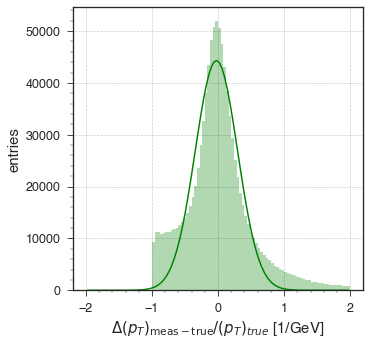

[INFO    ] # of entries: 150541, mean: 6.348870378905773, std: 10.699412709859644
[INFO    ] gaus fit (a, mu, sig): [7.70316000e+03 6.36024284e+00 7.32868045e+00]


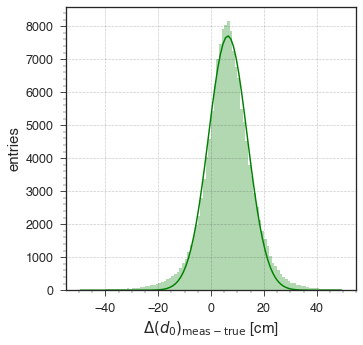

In [86]:
__generate_delta_plots__(model = qmodel,
                        x = x_test_displ,
                        y = y_test_displ,
                        dxy = dxy_test_displ
                        )

### Saving the optimal quantized model:

In [87]:
# model_for_export = qmodel
# qkeras_file = "models/quantized_DNN.h5"
# weights_file = "models/quantized_DNN_weights"
# # save quantized weights
# utils.model_save_quantized_weights(model_for_export, weights_file)
# # save keras.save() h5 version of quantized model
# tf.keras.models.save_model(model_for_export, qkeras_file, include_optimizer=False)
# print('Saved quantized Keras model to:', qkeras_file)

### Loading the quantized model for assessment:

In [88]:
# qkeras_file = "models/quantized_DNN.h5"
# weights_file = "models/quantized_DNN_weights"
# loaded_qmodel = utils.load_qmodel(filepath=qkeras_file)

In [89]:
# loaded_qmodel.load_weights(weights_file)

In [90]:
# loaded_qmodel.summary()

In [91]:
# utils.get_model_sparsity(model=loaded_qmodel,per_layer=True)

In [92]:
## END ############################################################################################